<a href="https://colab.research.google.com/github/eomorozova/modeling_hcos/blob/main/HCO_models_analysis_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and helper functions

In [11]:
import numpy as np
import scipy as sp
import scipy.io

import matplotlib.pyplot as plt 
from matplotlib import rcParams
from matplotlib.pyplot import rc_context
import seaborn as sns
import copy

from scipy.stats import zscore
from sklearn.cluster import KMeans

!pip install -q scanpy
import scanpy as sc
sc.settings.verbosity = 3  

!pip install -q leidenalg

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [14]:
!pip install matplotlib==3.1.3
import matplotlib.pyplot as plt 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.9.1 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
# concatenate spiketimes

def concat(spiketimes):

  st = []

  for i in range(len(spiketimes)):
    
    st1=[]

    for j in range(len(spiketimes[i])):

      if spiketimes[i][j].any():
        st1.append(np.concatenate(spiketimes[i][j]))
      else:
        st1.append([])

    st.append(st1)
  
  return st

In [4]:
# delete multiple objects from a list 

def delete_multiple_element(list_object, indices):
    indices = sorted(indices, reverse=True)
    for idx in indices:
        if idx < len(list_object):
          list_object.pop(idx)

# Load spiketimes

In [5]:
#load spiketime data

from google.colab import files
uploaded = files.upload()

Saving hco_model_data.mat to hco_model_data.mat


In [6]:
mat  = scipy.io.loadmat('/content/hco_model_data.mat')
#mat.keys()
allprtile = mat.get('allprtile') # z-scored feature vector (ISIs, phases)
spiketimes = mat.get('st') # spiketimes

In [7]:
st = concat(spiketimes) # concatinated spiketimes

In [10]:
# number of models with escape and release 10% asymmerty and 100% asymetry

ie10 = mat.get('ie10')[0][0]
ir10 = mat.get('ir10')[0][0]
ie100 = mat.get('ie100')[0][0]
ir100 = mat.get('ir100')[0][0]

# Generate synthetic spiketime data

In [ ]:
# function to generate synthetic spiketime data from a Poisson distribution

def generate_st(lambda1):
  s = np.random.poisson(lambda1)
  spikes = []
  time = np.random.poisson(lambda1)

  while (time < 900):
    spikes.append(time)
    time = time + np.random.poisson(lambda1)

  return spikes

In [ ]:
# generate spiketimes for two nerurons
st = []
lambda1=[5,10]

for j in range(2):
  st1 = []
  for i in range(10):
    st1.append(generate_st(lambda1[j]))

  st.append(st1)


# Functions for burst identification and classification of activity patterns

In [102]:
# detect bursts and calculate burst statistics

#def DetectBursts(spiketimes, startISI=None, stopISI=None, minspikes=None):
def DetectBursts(spiketimes, startISI=None, stopISI=None, minspikes=None):
  
  """
  Args:
    spiketimes: spike times of both neurons
    startISI: inter-spike interval to start a burst (in secnds)
    endISI: inter-spike interval to end a burst (in secods)
    minspikes: minimun number of spikes in a burst  

  Returns:
    burst: dictionary with the following collction of key-value pairs
      'N': burst number
      'Nspk': number of spikes per burst
      'FirstSpike': burst onset
      'LastSpike': burst offset
      'BurstDur': burst duration
      'BurstFreq': inter-burst frequency
      'SpkFreq': mean frequency of spikes within bursts

  """
  # defaults
  if startISI is None:
    startISI = np.mean(np.diff(spiketimes))
  if stopISI is None:
    stopISI = startISI + 1
  if minspikes is None:
    minspikes = 2
  
  burst = dict()
  burston, burstoff, burstdur, Nspks = [], [], [], []

  k = 0 # burst counter

  inburst = False

  for i in range(len(spiketimes)):

    
    if i+1<len(spiketimes):

      if (inburst is False) & (spiketimes[i+1]-spiketimes[i]<startISI):

        inburst = True
        k+=1

        firstspike = spiketimes[i]
        burston.append(firstspike)

        nspks = 2 # spike counter

      elif (inburst is True) & (spiketimes[i+1]-spiketimes[i]<stopISI):

        nspks+=1

      else: # check if the number of spikes per burst is more than minimin requires number

        if inburst is True:
          if nspks>=minspikes:

            lastspike = spiketimes[i]
            burstoff.append(lastspike)

            bd = lastspike - firstspike
            burstdur.append(bd)

            Nspks.append(nspks)

        inburst = False

  burstfreq = 1/np.diff(burston)
  spkfreq = Nspks/np.array(burstdur)

  burst = {'N': list(range(1,k)), 'Nspks': Nspks, 'FirstSpike': burston, 'LastSpike': burstoff, 'BurstDur': burstdur, 'BurstFreq': burstfreq, 'SpkFreq': spkfreq.tolist()}

  return burst


In [169]:
# calculate the exclusion factor (based on Grashow et al., 2009)

def Xnetwork(Burst,T):

  """
  Args:
    TimeInterval1: Active time intervals of the 1st neuron, where
      each row contains start end times of the activity periods
    TimeInterval1: Active time intervals of the 2nd neuron
    T: Total simulation time  

  Returns:
    xnetwork: Exclusion factor 
  """
  
  # total active time of the first neuron
  t1 = np.sum(Burst[0]['BurstDur'])

   # total active time of the first neuron
  t2 = np.sum(Burst[1]['BurstDur'])

  if len(Burst[0]['FirstSpike']) > len(Burst[0]['LastSpike']):
    #TimeInterval1 = np.vstack((Burst[0]['FirstSpike'][:-1], Burst[0]['LastSpike'])).T
    TimeInterval1 = np.vstack((Burst[0]['FirstSpike'][0:len(Burst[0]['LastSpike'])], Burst[0]['LastSpike'])).T
  elif len(Burst[0]['FirstSpike']) < len(Burst[0]['LastSpike']):    
    TimeInterval1 = np.vstack((Burst[0]['FirstSpike'], Burst[0]['LastSpike'][0:len(Burst[0]['FirstSpike'])])).T  
  else:
    TimeInterval1 = np.vstack((Burst[0]['FirstSpike'], Burst[0]['LastSpike'])).T    
  
  if len(Burst[1]['FirstSpike']) > len(Burst[1]['LastSpike']):
    #TimeInterval2 = np.vstack((Burst[1]['FirstSpike'][:-1], Burst[1]['LastSpike'])).T  
    TimeInterval2 = np.vstack((Burst[1]['FirstSpike'][0:len(Burst[1]['LastSpike'])], Burst[1]['LastSpike'])).T    
  elif len(Burst[1]['FirstSpike']) < len(Burst[1]['LastSpike']):
    TimeInterval1 = np.vstack((Burst[1]['FirstSpike'], Burst[1]['LastSpike'][0:len(Burst[1]['FirstSpike'])])).T  
  else:
    TimeInterval2 = np.vstack((Burst[1]['FirstSpike'], Burst[1]['LastSpike'])).T

  if len(TimeInterval1)>len(TimeInterval2):
    TimeInterval1=TimeInterval1[0:len(TimeInterval2)]
  
  if len(TimeInterval2)>len(TimeInterval1):
    TimeInterval2=TimeInterval2[0:len(TimeInterval1)]

  ActiveTime =[]

  for i in range(len(TimeInterval1)):
    SortedIntervals = sorted(TimeInterval1[i].tolist() + TimeInterval2[i].tolist())
    ActiveTime.append(SortedIntervals[-1] - SortedIntervals[0])

  TotalActiveTime = np.sum(ActiveTime)

  # calculate the overlap time (when both neurons are active)
  Onetwork = t1 + t2 - TotalActiveTime

  T=90
  # calculate minimum overlap time between the spiketrains (Omin)
  if t1+t2>T:
    Omin = T - (t1+t2)
  else:
    Omin = 0

  # calculate overlap time expected for uncorrelated inouts  
  if t1+t2>T:
    Orandom = np.min([t1,t2]) - 1/2*(T - np.max([t1,t2]))
  else:
    Orandom = np.min([t1,t2])**2/(2*(T-np.max([t1,t2])))

  # callulate the exclusion factor
  xnetwork = (Orandom - Onetwork)/(Orandom - Omin)

  return xnetwork 

In [111]:
# function to aclassify network activity patterns into silent, asymmetric spiking, irregular spiking, alternating spiking and alternating bursting (half-center oscillator)

def ClassifyActivity(spiketimes):

  """
  Args:
    spiketimes: spike times of both neurons

  Returns:
    state: Activity pattern
      state = 0: Silent
      state = 1: Asymmetric tonic
      state = 2: Asymmetric bursting
      state = 3: Irregular
      state = 4: Alternating bursting

  """

  # 1) silent -> no spikes occur for either neuron
  if (len(spiketimes[0])<1) & (len(spiketimes[1])<1):
      state = 0

  # 2) asymmetric -> only one of the neurons have spikes
  elif ((len(spiketimes[0])<1) & ((len(spiketimes[1])>1))) | ((len(spiketimes[0])>1) & ((len(spiketimes[1])<1))):
    Burst=[]
    for i in range(len(st)):
      burst = DetectBursts(spiketimes[i], np.mean(np.diff(spiketimes[i])), np.mean(np.diff(spiketimes[i]))+0.1, 2)
      Burst.append(burst)

      # asymmetric tonic
      if len(Burst[0]['N'])<1:
        state = 1 # tonic

      # asymmetric bursting
      else:
        state = 2 

  else:
    Burst=[]
    for i in range(len(st)):
      burst = DetectBursts(spiketimes[i], np.mean(np.diff(spiketimes[i])), np.mean(np.diff(spiketimes[i]))+1, 1)
      Burst.append(burst)
      
    # 3) irregular -> both neurons fire irregularly
    if len(Burst[0]['N'])<1:
      state = 3

    else:
      T = 90 # total time
      xnetwork = Xnetwork(Burst,T)

      # 3) irregular -> both neurons fire irregularly
      if xnetwork<0.1:
        state = 3

      # 4) half-center -> alternating bursting
      else:
        state = 4

  return state 


# Classification of the activity patterns

3.3430012246362177
4


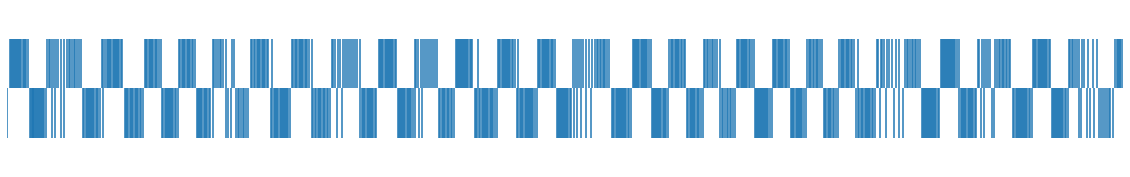

In [170]:
# detect bursts and calculate burst statistics

j=84
plt.figure(figsize=(20,3))
plt.eventplot([st[0][j], st[1][j]])
plt.xlim((0,90))
plt.axis('off')

Burst=[]
for i in range(len(st)):
  burst = DetectBursts(st[i][j], np.mean(np.diff(st[i][j])), np.mean(np.diff(st[i][j]))+1, 2)
  Burst.append(burst)

T = 90 # total time
xnetwork = Xnetwork(Burst,T)
print(xnetwork)
 
state = ClassifyActivity([st[0][j], st[1][j]])

print(state)

In [171]:
State =[]
for j in range(len(st[0])):
  state = ClassifyActivity([st[0][j], st[1][j]])
  State.append(state)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in double_scalars


# Functions to calculate percentiles of ISIs and spike phases and other spike train features 

In [14]:
# ISIs and percentiles of ISIs

def ISIPercentile(spiketimes):

  isiprtile = []

  for j in range(len(spiketimes)):

    isiprtile1=[]

    for i in range(len(spiketimes[j])):
      
      if (len(spiketimes[j][i])>1):
        #ISI = np.diff(np.concatenate(spiketimes[j][i]))
        ISI = np.diff(spiketimes[j][i])
        isiprtile1.append(np.percentile(ISI,range(0,100,10)).tolist())
      else:
        #isiprtile1.append([])
        isiprtile1.append([0]*10)

    isiprtile.append(isiprtile1)

  return isiprtile


In [15]:
# spike phases and phase percentiles

def PhasePrtile(spiketimes):

  phasesprtile1, phasesprtile2 = [], []

  # phases for the first neuron

  for i in range(len(spiketimes[0])):

    prevspk1,nextspk1,spkphase1 = [],[],[]
    prevspk2,nextspk2,spkphase2 = [],[],[]

    #if (spiketimes[0][i].any()) & (spiketimes[1][i].any()):
    if (len(spiketimes[0][i])!=0) & (len(spiketimes[1][i])!=0):

      #st1 = np.concatenate(spiketimes[0][i])
      #st2 = np.concatenate(spiketimes[1][i])
      st1 = spiketimes[0][i]
      st2 = spiketimes[1][i]
      
      if (max(st2)>min(st1)) & (max(st1)>min(st2)) & (len(st1)>10) & (len(st2)>10):

        # phases of the 1st neuron
        for j in range(len(st1)):

          prev_other_spikes1 = st2[np.where(st2<st1[j])]

          if not prev_other_spikes1.any():
            continue
          else:
            prev_other_spike1 = prev_other_spikes1[-1]
              
          next_other_spikes1 = st2[np.where(st2>st1[j])]

          if not next_other_spikes1.any():
            continue
          else:
            next_other_spike1 = next_other_spikes1[0]

          prevspk1.append(prev_other_spike1)
          nextspk1.append(next_other_spike1)

          spkphase1.append((st1[j] - prev_other_spike1)/(next_other_spike1 - prev_other_spike1))

        # phases of the 2nd neuron
        for j in range(len(st2)):

          prev_other_spikes2 = st1[np.where(st1<st2[j])]

          if not prev_other_spikes2.any():
            continue
          else:
            prev_other_spike2 = prev_other_spikes2[-1]
              
          next_other_spikes2 = st1[np.where(st1>st2[j])]

          if not next_other_spikes2.any():
            continue
          else:
            next_other_spike2 = next_other_spikes2[0]

          prevspk2.append(prev_other_spike2)
          nextspk2.append(next_other_spike2)

          spkphase2.append((st2[j] - prev_other_spike2)/(next_other_spike2 - prev_other_spike2))

      else:
        spkphase1, spkphase2 = [], []

      if spkphase1:
        phasesprtile1.append(np.percentile(spkphase1,range(0,100,10)))
      else:
        phasesprtile1.append([0]*10)

      if spkphase2:
        phasesprtile2.append(np.percentile(spkphase2,range(0,100,10)))
      else:
        phasesprtile2.append([0]*10)

    else:
      phasesprtile1.append([0]*10)
      phasesprtile2.append([0]*10)



  return phasesprtile1, phasesprtile2

In [16]:
# calculate firing rates

def FiringRate(spiketimes):

  FR = np.empty(shape=(len(spiketimes),len(spiketimes[0])))

  for j in range(len(spiketimes)):
    for i in range(len(spiketimes[j])):  
      if (len(spiketimes[j][i])>1):
        ISI = np.diff(spiketimes[j][i])
        FR[j,i] = np.median(1/ISI)
      else: 
        FR[j,i] = 0

  return FR

In [17]:
# calculate ciefficient of variation of spike trains

from scipy.stats import variation 

def ISICV(spiketimes):

  ISICV = np.empty(shape=(len(spiketimes),len(spiketimes[0])))

  for j in range(len(spiketimes)):
    for i in range(len(spiketimes[j])):  
      if (len(spiketimes[j][i])>1):
        ISI = np.diff(spiketimes[j][i])
        ISICV[j,i] = variation(ISI)

  return ISICV


In [18]:
# calculate a metrics for the first approximation of how burst-like spike train is

def BurstLike(spiketimes):

  burstlike = np.empty(shape=(len(spiketimes),len(spiketimes[0])))

  for j in range(len(spiketimes)):

    for i in range(len(spiketimes[j])):
      
      if (len(spiketimes[j][i])>2):
        ISI = np.diff(spiketimes[j][i])
        sortedISI = sorted(ISI)
        maxdiffs = max(np.diff(sortedISI))
        argmaxdiffs = np.argmax(np.diff(sortedISI))
        burstlike[j,i] = maxdiffs/sortedISI[argmaxdiffs]
      else:
        burstlike[j,i] = 0

  return burstlike

# Calculate percentiles of ISI and spike phases, firing rates and measure of burstiness

In [19]:
# remove asymmetric networks with one tonically spiking neuron

ISI_CV = ISICV(st) # calculate coefficient of variation of ISIs

st_ = copy.deepcopy(st)

tonic_i = np.argwhere(ISI_CV[0,:]<0.1)

def delete_multiple_element(list_object, indices):
    indices = sorted(indices, reverse=True)
    for idx in indices:
        if idx < len(list_object):
          list_object.pop(idx)

delete_multiple_element(st_[0], tonic_i.T[0])
delete_multiple_element(st_[1], tonic_i.T[0])


In [11]:
isiprtile = ISIPercentile(st) # percentiles of ISIs 
phaseprtile = PhasePrtile(st) # percentiles of spike phases
FR = FiringRate(st) # median firing rates
burstlike = BurstLike(st) # how burstlike the spike train is

In [20]:
# caluclate features of non tonic neurons

isiprtile = ISIPercentile(st_) # percentiles of ISIs 
phaseprtile = PhasePrtile(st_) # percentiles of spike phases
FR = FiringRate(st_) # median firing rates
burstlike = BurstLike(st_) # how burstlike the spike train is

(0.0, 1.0)

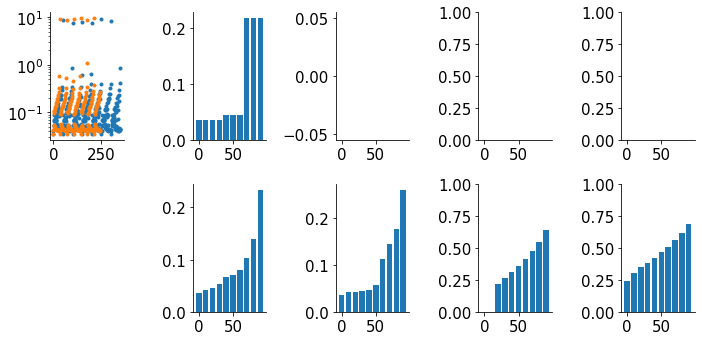

In [21]:
# plot example ISIs, spike phases and ISI and phases tenth percentiles
i=7

plt.figure(figsize=(10,5))
plt.subplot(2,5,1)
if spiketimes[0][i].any():
  plt.plot(np.diff(np.concatenate(spiketimes[0][i])),'.')
if spiketimes[1][i].any():
  plt.plot(np.diff(np.concatenate(spiketimes[1][i])),'.')
plt.yscale('log')
#plt.plot((np.diff(st[0][i])))
#plt.plot(np.diff(st[1][i]))

#isiprtile
plt.subplot(2,5,2)
if isiprtile[0][i]:
  plt.bar(range(0,100,10), isiprtile[0][i],width=8)

plt.subplot(2,5,3)
if isiprtile[1][i]:
  plt.bar(range(0,100,10), isiprtile[1][i],width=8)

plt.subplot(2,5,4)
if phaseprtile[0][i] != []:
  plt.bar(range(0,100,10), phaseprtile[0][i],width=8)
  plt.ylim(0, 1)

plt.subplot(2,5,5)
if phaseprtile[1][i] != []:
  plt.bar(range(0,100,10), phaseprtile[1][i],width=8)
  plt.ylim(0, 1)

plt.subplot(2,5,7)
plt.bar(range(0,100,10), allprtile[i][:10],width=8)
plt.subplot(2,5,8)
plt.bar(range(0,100,10), allprtile[i][10:20],width=8)
plt.subplot(2,5,9)
plt.bar(range(0,100,10), allprtile[i][20:30],width=8)
plt.ylim(0, 1)
plt.subplot(2,5,10)
plt.bar(range(0,100,10), allprtile[i][30:40],width=8)
plt.ylim(0, 1)

In [22]:
# make a feature vector and z-score it

features = np.hstack((isiprtile[0], isiprtile[1], phaseprtile[0], phaseprtile[1]))
features1 = np.append(features, FR.T, axis=1)
features2 = np.append(features1, burstlike.T, axis=1)
scaled_features = zscore(features2)

# FI-t-SNE approximate algorithm

In [ ]:
#@title Clone FFT-accelerated t-SNE repository
import os, requests
import sys

!git clone https://github.com/KlugerLab/FIt-SNE.git 
!apt-get install libfftw3-dev
!g++ -std=c++11 -O3  /content/FIt-SNE/src/sptree.cpp /content/FIt-SNE/src/tsne.cpp /content/FIt-SNE/src/nbodyfft.cpp  -o /content/FIt-SNE/bin/fast_tsne -pthread -lfftw3 -lm -Wno-address-of-packed-member

sys.path.append(os.path.abspath('/content/FIt-SNE/'))
from fast_tsne import fast_tsne 

In [24]:
# Do PCA and keep 50 dimensions

X = scaled_features.copy()
X = X - X.mean(axis=0)
U, s, V = np.linalg.svd(X, full_matrices=False)
X50 = np.dot(U, np.diag(s))[:,:50]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(-97.06781364931054, 90.63789419156983, -74.41713805532792, 77.58346028065591)

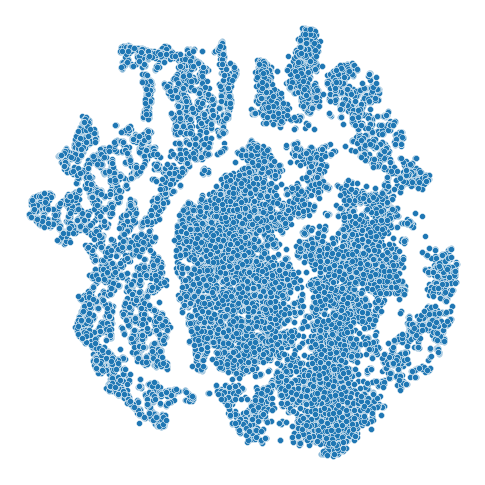

In [27]:
# calculate and plot tsne

#Z = fast_tsne(allprtile_scaled, perplexity=50, stop_early_exag_iter=250)
Z = fast_tsne(X50, perplexity=50, stop_early_exag_iter=250)

plt.figure(figsize=(7,7))
sns.scatterplot(Z[:,0], Z[:,1])
plt.axis("off")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

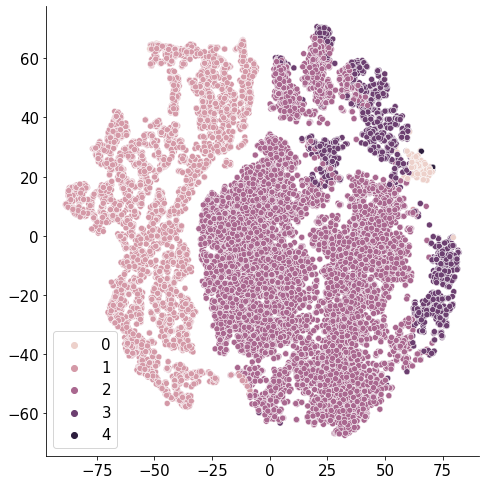

In [26]:
# K-means clustering

#kmeans = KMeans(n_clusters=5, random_state=0).fit(Z)
#kmeans = KMeans(n_clusters=5, random_state=0).fit(scaled_features)
kmeans = KMeans(n_clusters=5, random_state=0).fit(X50)

plt.figure(figsize=(7,7))
sns.scatterplot(Z[:,0], Z[:,1],hue = kmeans.labels_)
plt.axis("off")

# Standard t-SNE/ UMAP, Leiden 

In [28]:
# make annotated data matrix

adata = sc.AnnData(scaled_features, dtype=np.float32)
#adata = sc.AnnData(X50)
print(adata)

AnnData object with n_obs × n_vars = 23284 × 44


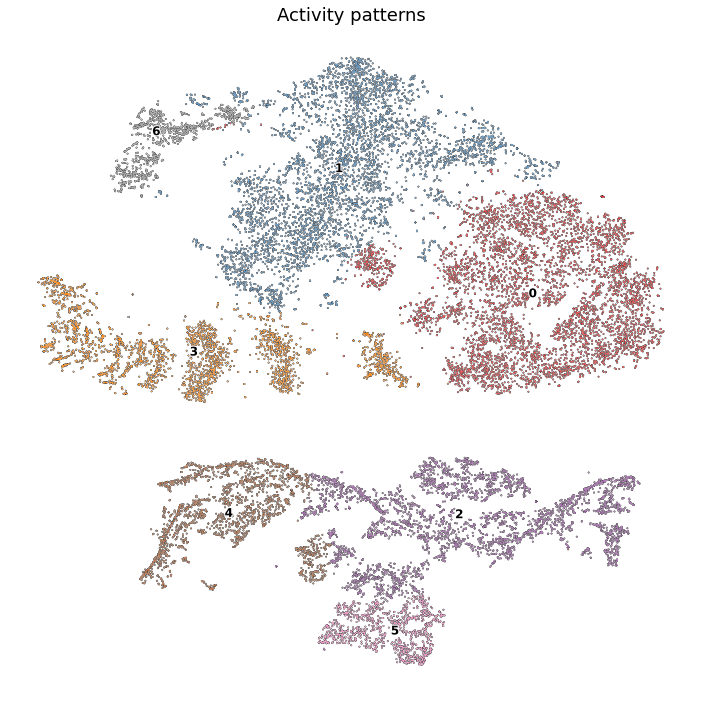

In [49]:
# t-SNE

sc.tl.tsne(adata,perplexity=100,n_pcs=10)
#sc.tl.tsne(adata,perplexity=100, random_state=1)

with rc_context({'figure.figsize': (10, 10)}):
  sc.pl.tsne(adata, color='clusters', add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2,frameon=False,
               title='Activity patterns', palette='Set1')
  

In [244]:
#Computing the neighborhood graph and cluster spiking patterns using the Leiden algorithm

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
#sc.pp.neighbors(adata, method="umap", n_neighbors=10)
sc.tl.leiden(adata, key_added='clusters', resolution=0.2)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 17 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:01)


In [235]:
# get indexes of identified clusters

clusters_idx=[0]*7

for i in range(7):
  clusters_= adata.obs.clusters==str(i)
  idxx = clusters_[clusters_].index
  clusters_idx[i] = int(idxx[5])

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:30)


<Figure size 720x720 with 0 Axes>

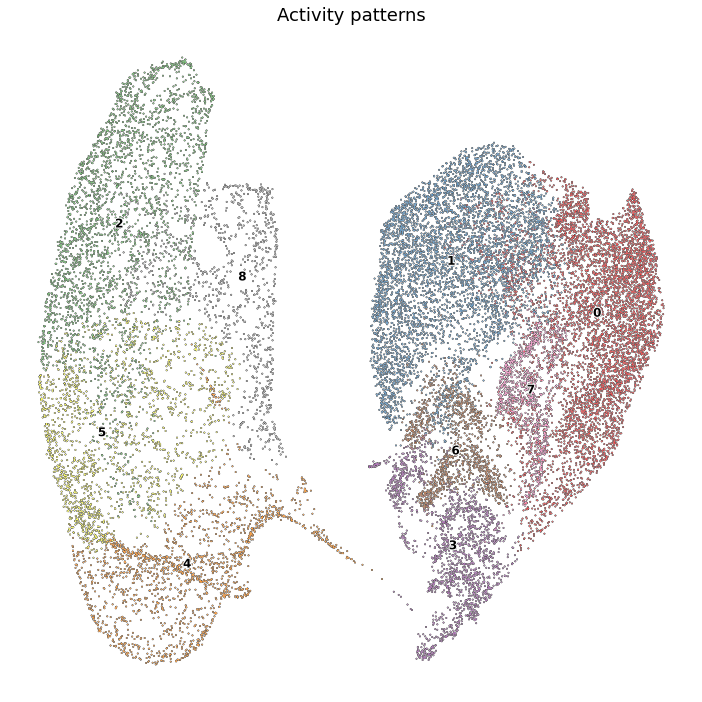

In [243]:
# UMAP   

#sc.tl.umap(adata,min_dist=0.1,gamma=0.1,init_pos=Z)
#sc.tl.umap(adata,min_dist=0.5,gamma=0.1,init_pos='paga')
sc.tl.umap(adata,min_dist=0.5,gamma=0.1)

plt.figure(figsize=(10,10))

with rc_context({'figure.figsize': (10, 10)}):
  sc.pl.umap(adata, color='clusters', add_outline=True, legend_loc='on data',
                legend_fontsize=12, legend_fontoutline=2,frameon=False,
                title='Activity patterns', palette='Set1')


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


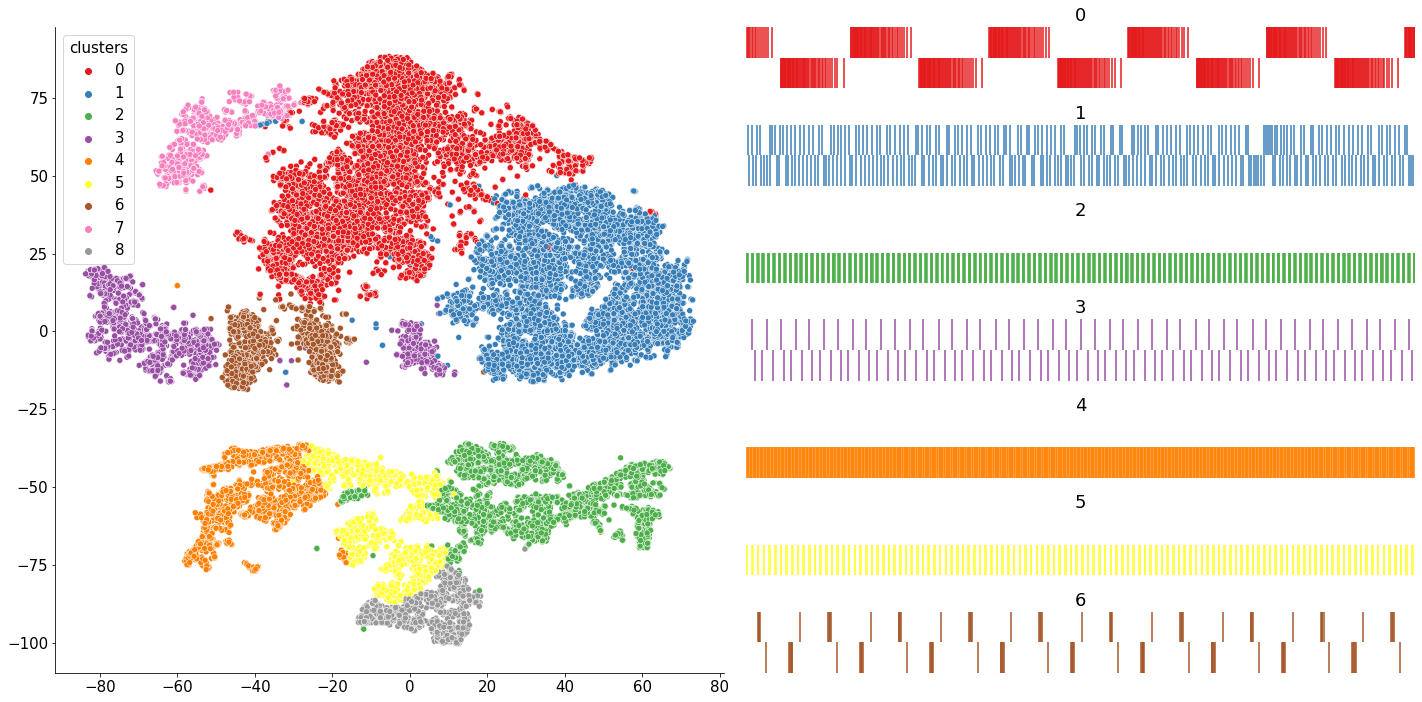

In [242]:
# plot t-SNE colorcoded by Leiden clusters and example spiking patterns

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.scatterplot(adata.obsm['X_tsne'][:,0], adata.obsm['X_tsne'][:,1], hue = adata.obs.clusters, palette=cmap.colors)

cmap=plt.cm.get_cmap('Set1')

for i in range(7):

  plt.subplot(7,2,2*(i+1))
  plt.eventplot([st_[0][clusters_idx[i]], st_[1][clusters_idx[i]]], colors=cmap.colors[i])
  plt.ylim(-0.5,1.5)
  plt.xlim(0,50)
  plt.axis('off')
  plt.title(str(i))


In [201]:
adata.obsm.X


array([-55.055443,  42.0932  ,  43.294926, ..., -51.78199 ,  31.627558,
       -39.568863], dtype=float32)

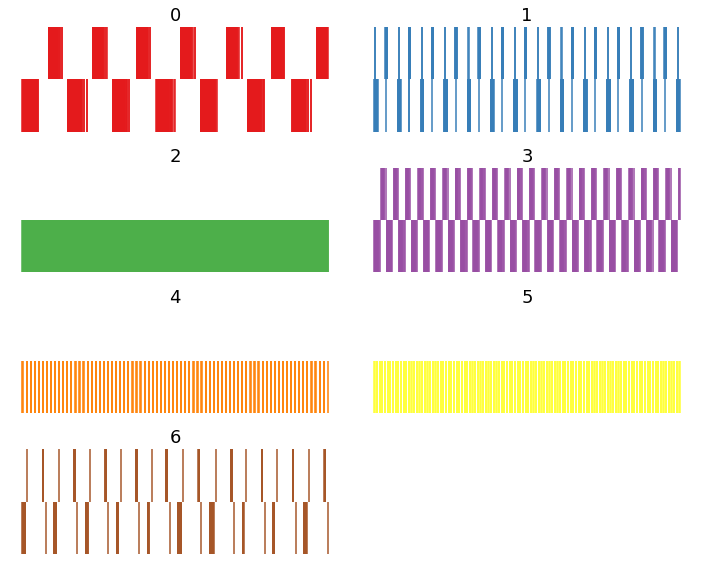

In [178]:
plt.figure(figsize=(10,10))

cmap=plt.cm.get_cmap('Set1')

for i in range(7):

  plt.subplot(5,2,i+1)
  plt.eventplot([st_[0][clusters_idx[i]], st_[1][clusters_idx[i]]], colors=cmap.colors[i])
  plt.ylim(-0.5,1.5)
  plt.axis('off')
  plt.title(str(i))

In [ ]:
sc.tl.paga(adata,groups='clusters')
sc.pl.paga(adata, plot=False) 

In [ ]:
plt.figure(figsize=(10,10))
sc.pl.tsne(adata, color='leiden',add_outline=True)